In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import import_ipynb
from Model import DigitCNN


In [2]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file):
        data = pd.read_csv(csv_file)
        self.labels = torch.tensor(data.iloc[:, 0].values, dtype=torch.long)
        self.images = torch.tensor(data.iloc[:, 1:].values.reshape(-1, 1, 28, 28), dtype=torch.float32) / 255.0

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [3]:
dataset = MNISTDataset('mnist_train.csv')
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DigitCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [4]:
# Initialize a list to store the loss values for each epoch
epoch_losses = []

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Compute the average loss for the epoch and append it to the list
    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    


# After the loop, `epoch_losses` will contain the loss for each epoch


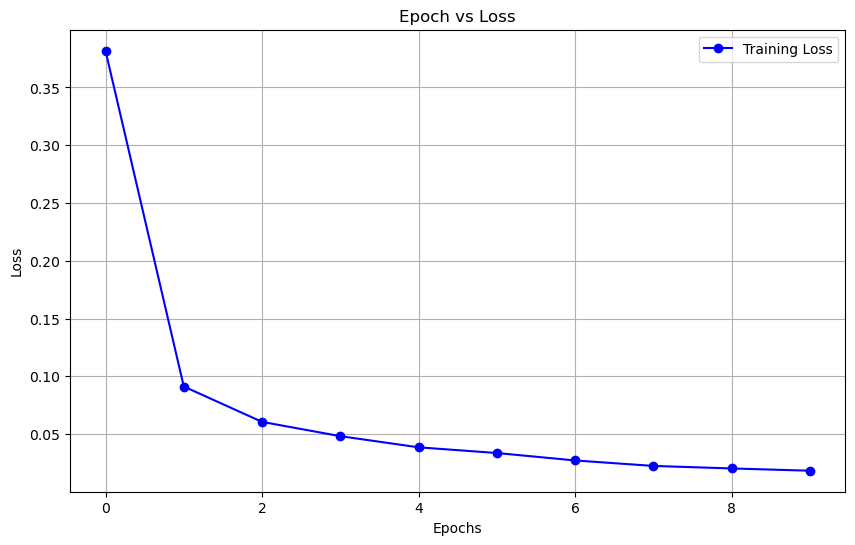

In [5]:
epochs=[]
for i in range(10):
    epochs.append(i)
plt.figure(figsize=(10, 6))
plt.plot(epochs,epoch_losses, marker='o', color='b', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
model.eval()
correct = 0
total = 0
misclassified_images = []
misclassified_labels = []
predicted_labels = []
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        misclassified_idx = (predicted != labels).nonzero(as_tuple=True)[0]
        misclassified_images.extend(images[misclassified_idx].cpu())
        misclassified_labels.extend(labels[misclassified_idx].cpu())
        predicted_labels.extend(predicted[misclassified_idx].cpu())
        
        all_labels.extend(labels.cpu())
        all_predictions.extend(predicted.cpu())

print(f'Accuracy: {100 * correct / total:.2f}%')


Accuracy: 98.78%


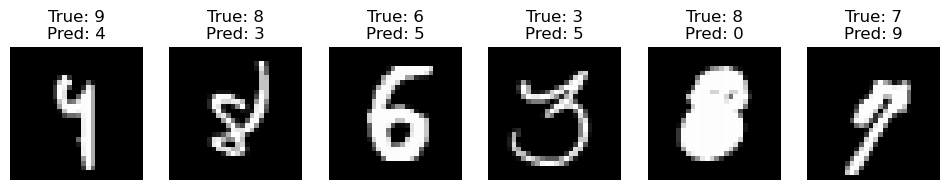

In [7]:
fig, axes = plt.subplots(1, 6, figsize=(12, 4))
for i in range(min(6, len(misclassified_images))):
    ax = axes[i]
    ax.imshow(misclassified_images[i].squeeze(), cmap='gray')
    ax.set_title(f'True: {misclassified_labels[i].item()}\nPred: {predicted_labels[i].item()}')
    ax.axis('off')
plt.show()

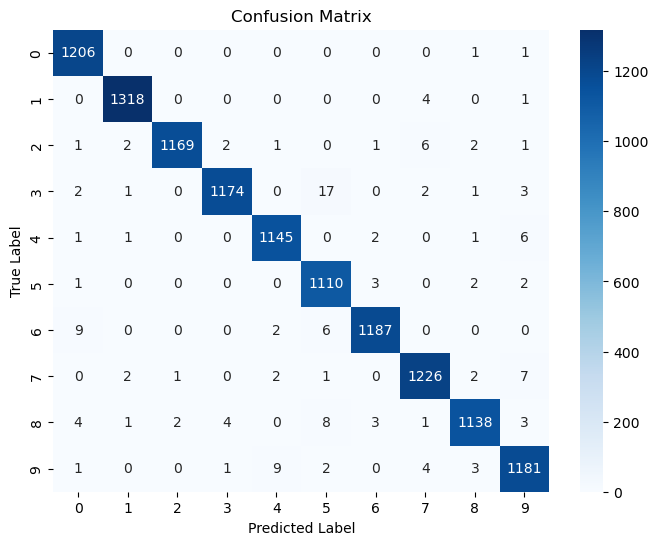

In [8]:
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [9]:
print("Classification Report:")
print(classification_report(all_labels, all_predictions))

precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1208
           1       0.99      1.00      1.00      1323
           2       1.00      0.99      0.99      1185
           3       0.99      0.98      0.99      1200
           4       0.99      0.99      0.99      1156
           5       0.97      0.99      0.98      1118
           6       0.99      0.99      0.99      1204
           7       0.99      0.99      0.99      1241
           8       0.99      0.98      0.98      1164
           9       0.98      0.98      0.98      1201

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000

Precision: 0.9877
Recall: 0.9878
F1 Score: 0.9877


In [10]:
torch.save(model.state_dict(), 'cnn_model_weights.pth')